## 实现方式
- 在原始数据的基础上加入一个特征工程，区间缩放法

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn import svm
from sklearn import metrics
from sklearn import preprocessing

In [2]:
np.random.seed(28)

In [3]:
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

In [5]:
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

In [6]:
stockcode = '000001.SZ'
stockname = '平安银行'
file_path = './data/000001.SZ_day_qfq.csv'
stockfile = pd.read_csv(file_path, index_col='trade_date', parse_dates=True)

In [7]:
def calc_profit(data, position_period=5):
    """
    计算持仓收益，并给定标签
    """
    price = data['close']
    data['profit'] = (data['close'].shift(-position_period) - price) / price * 100.0
    data['label'] = 0
    data.loc[data['profit'] > 1.0, 'label'] = 1

In [8]:
# 计算收益并给定标签
calc_profit(stockfile)

In [9]:
stockfile.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2551 entries, 2008-01-02 to 2018-10-31
Data columns (total 11 columns):
open          2551 non-null float64
high          2551 non-null float64
low           2551 non-null float64
close         2551 non-null float64
pre_close     2551 non-null float64
change        2551 non-null float64
pct_change    2551 non-null float64
vol           2551 non-null float64
amount        2551 non-null float64
profit        2546 non-null float64
label         2551 non-null int64
dtypes: float64(10), int64(1)
memory usage: 239.2 KB


## 一、特征属性分析
查看特征变量之间的关系

In [10]:
# 查看所有特征属性之间的相关性
corr = stockfile.corr()
corr.loc[:,:] = np.tril(corr, k=-1)
corr = corr.stack()
corr = corr[(corr > 0.5) | (corr < -0.5)]
corr

high        open      0.998200
low         open      0.998651
            high      0.997505
close       open      0.997121
            high      0.998778
            low       0.998336
pct_change  change    0.932152
vol         open      0.594773
            high      0.620646
            low       0.585415
            close     0.608256
amount      open      0.557333
            high      0.585513
            low       0.544733
            close     0.570341
            vol       0.951830
label       profit    0.715584
dtype: float64

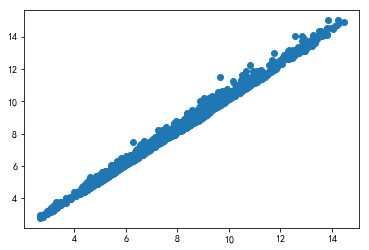

In [11]:
# 查看low和high的关联关系
plt.scatter(stockfile['low'], stockfile['high'])

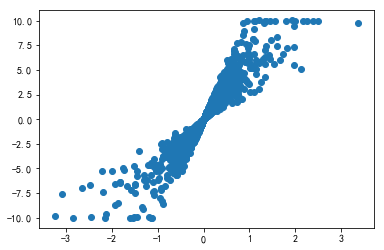

In [12]:
# 查看change和pct_change的关系
plt.scatter(stockfile['change'], stockfile['pct_change'])

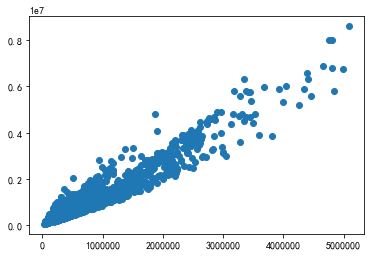

In [13]:
# 查看vol和amount的关联关系
plt.scatter(stockfile['vol'], stockfile['amount'])

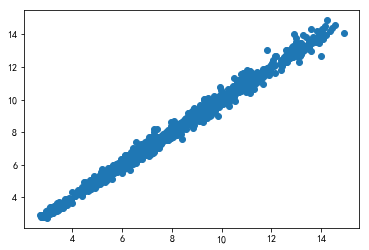

In [14]:
# 查看open和close的关系
plt.scatter(stockfile['open'], stockfile['close'])

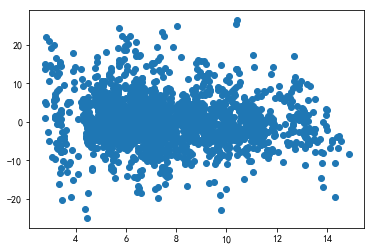

In [15]:
# 查看一下交易价格以及结果之间的关系
plt.scatter(stockfile['close'], stockfile['profit'])

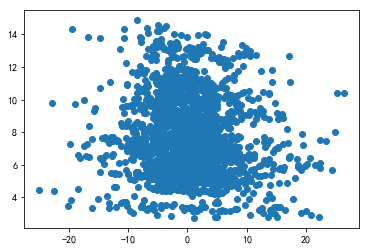

In [16]:
# 查看一下结果以及交易价格之间的关系
plt.scatter(stockfile['profit'], stockfile['close'])

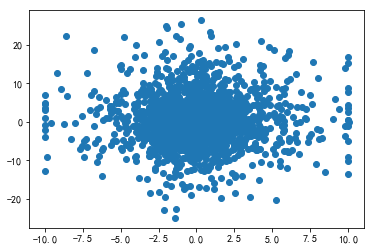

In [17]:
# 查看一下涨跌幅以及结果之间的关系
plt.scatter(stockfile['pct_change'], stockfile['profit'])

In [18]:
# 查看label和open、pct_change之间的关系
print(stockfile.groupby('label').agg({'pct_change':'mean', 'open':'mean'}))
print(stockfile.groupby('label').agg({'pct_change':'std', 'open':'std'}))

       pct_change      open
label                      
0        0.066832  7.610194
1       -0.017090  7.245057
       pct_change      open
label                      
0        2.385723  2.327652
1        2.690906  2.353765


### 总结：
最终发现基础的属性对于最终模型的预测结果都不是特别好
- 属性：open、high、low、close、pre_close之间的关联关系比较大
- 属性：change、pct_change两个属性直接的关联关系比较大
- 属性：vol、amount两个属性之间的关联关系比较大

初始模型构建

- 获取训练用数据和测试用数据

In [19]:
stockfile.info()
stock_data = stockfile.drop(['high', 'low', 'close', 'pct_change', 
                    'vol', 'profit'], axis=1)
stock_data.info()

split_idx = int(4.0 * stock_data.shape[0] / 5)
stock_train_data, stock_test_data = stock_data.iloc[:split_idx,:], stock_data.iloc[split_idx:, :]
print("训练数据格式:{}, 测试数据格式:{}".format(stock_train_data.shape, stock_test_data.shape))

# 获取收盘价
buy_price = stockfile['close']
train_data_buy_price = buy_price[:split_idx]
test_data_buy_price = buy_price[split_idx:]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2551 entries, 2008-01-02 to 2018-10-31
Data columns (total 11 columns):
open          2551 non-null float64
high          2551 non-null float64
low           2551 non-null float64
close         2551 non-null float64
pre_close     2551 non-null float64
change        2551 non-null float64
pct_change    2551 non-null float64
vol           2551 non-null float64
amount        2551 non-null float64
profit        2546 non-null float64
label         2551 non-null int64
dtypes: float64(10), int64(1)
memory usage: 239.2 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2551 entries, 2008-01-02 to 2018-10-31
Data columns (total 5 columns):
open         2551 non-null float64
pre_close    2551 non-null float64
change       2551 non-null float64
amount       2551 non-null float64
label        2551 non-null int64
dtypes: float64(4), int64(1)
memory usage: 119.6 KB
训练数据格式:(2040, 5), 测试数据格式:(511, 5)


* 数据分割

In [20]:
X = stock_data.drop('label', axis=1)
Y = stock_data['label']
x_train = stock_train_data.drop('label', axis=1)
x_test = stock_test_data.drop('label', axis=1)
y_train = stock_train_data['label']
y_test = stock_test_data['label']
print("训练数据格式:{}, 测试数据格式:{}".format(x_train.shape, x_test.shape))

训练数据格式:(2040, 4), 测试数据格式:(511, 4)


* 模型训练

In [21]:
# scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
scaler = preprocessing.MinMaxScaler(feature_range=(-10,10))
x_train = scaler.fit_transform(x_train, y_train)
x_test = scaler.transform(x_test)
X = scaler.transform(X)

In [22]:
algo = svm.SVC(probability=True)
algo.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

* 模型效果评估

In [23]:
y_pred_test = algo.predict(x_test)
y_pred_train = algo.predict(x_train)
y_pred_all = algo.predict(X)
print("训练数据准确率:{}".format(metrics.accuracy_score(y_train, y_pred_train)))
print("测试数据准确率:{}".format(metrics.accuracy_score(y_test, y_pred_test)))
print("训练数据的效果混淆矩阵:\n{}".format(metrics.confusion_matrix(y_train, y_pred_train)))
print("训练数据的效果report:\n{}".format(metrics.classification_report(y_train, y_pred_train)))
print("测试数据的效果混淆矩阵:\n{}".format(metrics.confusion_matrix(y_test, y_pred_test)))
print("测试数据的效果report:\n{}".format(metrics.classification_report(y_test, y_pred_test)))
print("所有数据准确率:{}".format(metrics.accuracy_score(Y, y_pred_all)))
print("所有数据的效果混淆矩阵:\n{}".format(metrics.confusion_matrix(Y, y_pred_all)))
print("所有数据的效果report:\n{}".format(metrics.classification_report(Y, y_pred_all)))


训练数据准确率:0.7102941176470589
测试数据准确率:0.6536203522504892
训练数据的效果混淆矩阵:
[[1192   69]
 [ 522  257]]
训练数据的效果report:
              precision    recall  f1-score   support

           0       0.70      0.95      0.80      1261
           1       0.79      0.33      0.47       779

   micro avg       0.71      0.71      0.71      2040
   macro avg       0.74      0.64      0.63      2040
weighted avg       0.73      0.71      0.67      2040

测试数据的效果混淆矩阵:
[[333   0]
 [177   1]]
测试数据的效果report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       333
           1       1.00      0.01      0.01       178

   micro avg       0.65      0.65      0.65       511
   macro avg       0.83      0.50      0.40       511
weighted avg       0.77      0.65      0.52       511

所有数据准确率:0.6989415915327323
所有数据的效果混淆矩阵:
[[1525   69]
 [ 699  258]]
所有数据的效果report:
              precision    recall  f1-score   support

           0       0.69      0.96      0.80      

#### 计算在当前模型情况下的，最终效果

In [24]:
def calc_rate_of_return_by_state(buy_price, buy_infos, initial_capital=100000.0):
    """
    buy_infos: 购买信息，True表示购买，False表示卖出
    :param buy_price: 价格信息
    :param buy_infos:
    :param initial_capital: 初始资本
    :return:
    """
    # 资本
    capital = initial_capital
    # 持有的股本
    hold_equity = 0.0

    flag = False
    for idx, buy_flag in enumerate(buy_infos):
        if buy_flag:
            # 当需要进行购买操作的时候，两种情况：如果之前就是购买，那就继续持有；否则全部买入
            if not flag:
                # 买入
                hold_equity = 1.0 * capital / buy_price[idx]
                flag = True
                capital = 0.0
        else:
            # 当需要进行卖出操作的时候，两种情况：如果之前就是卖出, 那么继续不买入；否则卖出
            if flag:
                # 卖出
                flag = False
                capital = hold_equity * buy_price[idx]
                hold_equity = 0.0

    # 计算最终的金额以及收益率
    total_capital = capital + hold_equity * buy_price[-1]
    return total_capital, (total_capital - initial_capital) / initial_capital


In [25]:
print("所有数据上")
print("原始随机情况下:")
buy_infos = np.ones_like(buy_price, dtype=np.bool)
buy_infos[::5] = False
print(calc_rate_of_return_by_state(buy_price, buy_infos))
print("模型预测情况下:")
buy_infos = y_pred_all.astype(np.bool)
print(calc_rate_of_return_by_state(buy_price, buy_infos))

所有数据上
原始随机情况下:
(124615.43419521823, 0.2461543419521823)
模型预测情况下:
(3106357.339846481, 30.06357339846481)


In [26]:
print("训练数据上")
print("原始随机情况下:")
buy_infos = np.ones_like(train_data_buy_price, dtype=np.bool)
buy_infos[::5] = False
print(calc_rate_of_return_by_state(train_data_buy_price, buy_infos))
print("模型预测情况下:")
buy_infos = y_pred_train.astype(np.bool)
print(calc_rate_of_return_by_state(train_data_buy_price, buy_infos))

训练数据上
原始随机情况下:
(97989.39091047984, -0.02010609089520163)
模型预测情况下:
(3094165.984509564, 29.94165984509564)


In [27]:
print("测试数据上")
print("原始随机情况下:")
buy_infos = np.ones_like(test_data_buy_price, dtype=np.bool)
buy_infos[::5] = False
print(calc_rate_of_return_by_state(test_data_buy_price, buy_infos))
print("模型预测情况下:")
buy_infos = y_pred_test.astype(np.bool)
print(calc_rate_of_return_by_state(test_data_buy_price, buy_infos))

测试数据上
原始随机情况下:
(127315.7470851489, 0.27315747085148906)
模型预测情况下:
(100394.01103230892, 0.003940110323089175)
